# Meteorological data processing

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [10]:
fto = './data/DATALOG.TXT' #  File to Open

print fto

l=[]
#l.extend(range(0,261))
l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$DIVISEK'][3]
print sn[0]


./data/DATALOG.TXT
1290c00806a20091302fa000a000004d


## Derive measurement runs in to separate files

In [11]:
run = 0

runs = []
LatDD = np.nan
LonDD = np.nan

for i,r in df.iterrows():
    if (r[0] == '$DIVISEK'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print run,
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        Lat = float(r[3])
        LatDD = (Lat/100)
        LatDD = LatDD + (Lat - 100.0*LatDD)/60.0
        LatDD = LatDD * LatS  
        Lon = float(r[5])
        LonDD = (Lon/100)
        LonDD = LonDD + (Lon - 100.0*LonDD)/60.0
        LonDD = LonDD * LonS         
        flag = 1
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        
    if (r[0] == '$STROKE'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
                
print

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob("./output/*.csv"): # delete all output files 
    print 'Deleting', f
    os.remove(f)


dfo.set_index('date', inplace = True)

for x in runs: 
    dfo.loc[dfo['run'] == x[0]].to_csv('./output/' + str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.csv')


1


## Plot

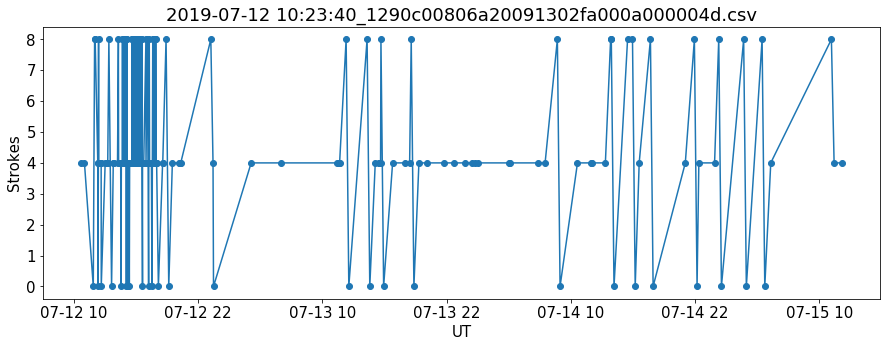

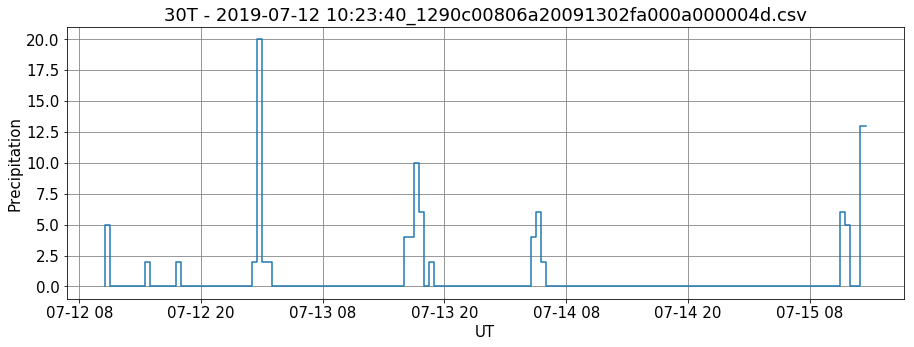

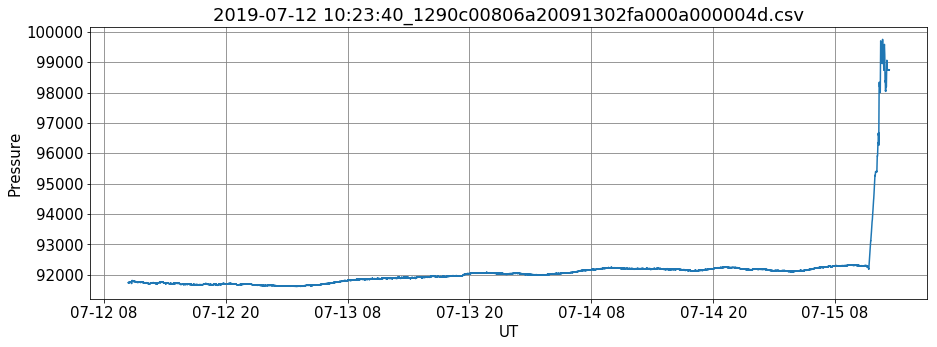

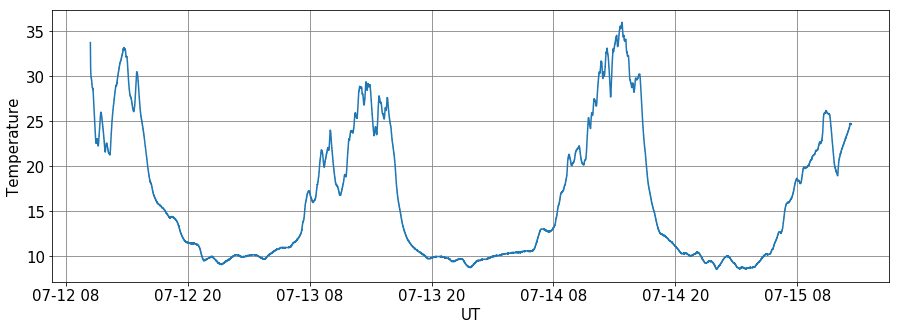

In [35]:
for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
        xx['12'] = pd.to_numeric(xx['12'])
        
        plt.figure(figsize=(15,5))
        plt.plot(xx['12'], marker='o')
        plt.title(s[len(s)-1])
        plt.xlabel('UT')
        plt.ylabel('Strokes')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '30T'
        xx = xx.resample(interval, label='right').sum()
        plt.figure(figsize=(15,5))
        #plt.tight_layout()
        plt.plot(xx['3'], drawstyle='steps-pre')
        plt.title(interval + ' - ' + s[len(s)-1])
        plt.xlabel('UT')
        plt.ylabel('Precipitation')
        plt.grid(b=True, which='major', color='grey', linestyle='-')
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        plt.figure(figsize=(15,5))
        plt.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        plt.grid(b=True, which='major', color='grey', linestyle='-')

        plt.title(s[len(s)-1])
        plt.xlabel('UT')
        plt.ylabel('Pressure')
        #plt.legend(loc=2)

        #ax = plt.twinx()
        plt.figure(figsize=(15,5))                                         
        plt.plot(xx['5'])
        plt.xlabel('UT')
        plt.ylabel('Temperature')
        #plt.autoscale()       
        plt.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
                
    except:
        pass



# Plot Map

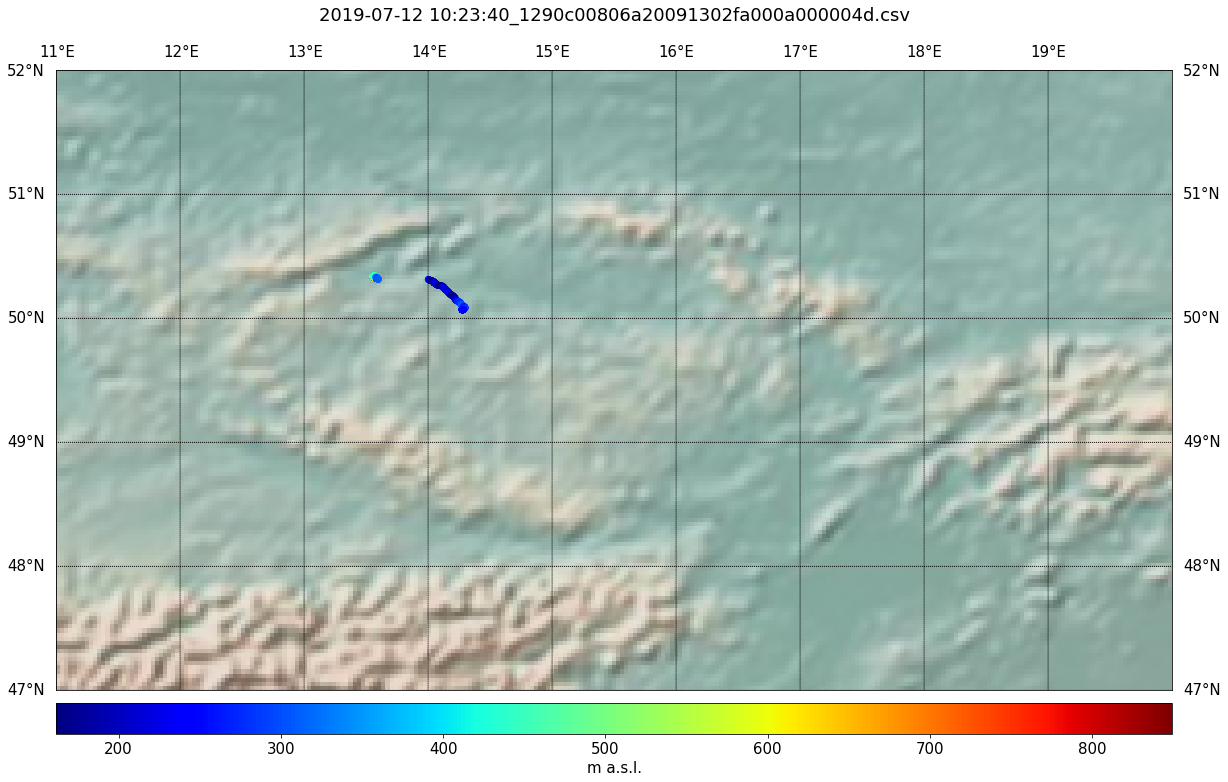

In [30]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(20,20))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        #m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
        m.shadedrelief()
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        #plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


## Read log mlynek

In [72]:
fto = './data/DATALOG.TXT' #  File to Open

print fto

#l.extend(range(0,261))
df = pd.read_table(fto, sep=',', header=None, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$TIME'].index, inplace=True)
#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
#df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
#df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
#df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)



./data/DATALOG.TXT


In [74]:
#plt.plot(df[2])
df.shape

(2174800, 3)

<IPython.core.display.Javascript object>


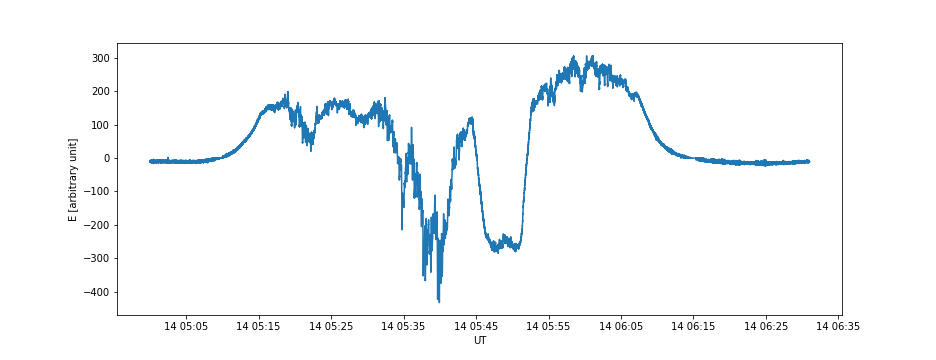

In [87]:
%matplotlib notebook

df['time'] = pd.to_datetime(pd.to_datetime('2019-07-12 14:40') + pd.to_timedelta(df.index*0.1133846790509479, unit='s'))

rc = df
rc = rc.set_index(['time'])

rc = rc.loc['2019-07-14 5:00':'2019-07-14 6:30']

plt.figure(figsize=(13,5))
plt.plot(rc[2])
#plt.locator_params(axis='x',nbins=40)
plt.xlabel('UT')
plt.ylabel('E [arbitrary unit]')

plt.show()